In [200]:
# Nisha's Lab Data Analysis

In [201]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

# initialize this way so that `plt.show()` is not needed @ cell to display plot
%matplotlib inline

In [202]:
def do_process(xslx_file, folder):
    # time_course_df = pd.read_excel(xslx_file, 'sheet_name = 0 is default', index_col=None, na_values=[0], skiprows=6) 
    # Read excel xslx_file with sheet number 0 to dataframe
    time_course_df = pd.read_excel(xslx_file, sheet_name=0, index_col=0, parse_dates=True, skiprows=6) # set indexed column 'Timestamp' and dates in excel is parsed as datatime type

    # CFP data frame till # 75
    cfp_df = time_course_df.iloc[0:75]

    # YFP part starts here # 156
    yfp_df = time_course_df.iloc[156:231]

    # E-FRET part starts here # 234
    efret_df = time_course_df.iloc[234:]
    # cleaning the empty value -- to 0.00
    efret_df = efret_df.replace('--', 0)
    # Finding the Background column containing '-1.#IND0'
    background_col = [col for col, ser in efret_df.iteritems() if ser.astype(str).str.match('-1.#IND0*').any()] # find the background column from the E-FRET data frame

    # Set background column N/A
    efret_df[background_col] = np.nan

    # background column's index
    background_col_index = efret_df.columns.get_loc(background_col[0])

    # Corrected CFP data frame
    corrected_cfp_df = pd.DataFrame()
    for c in cfp_df.columns:
        corrected_cfp_df[c] = cfp_df.apply(lambda row: row[c] - row[cfp_df.columns[background_col_index]] if row[c] != row[cfp_df.columns[background_col_index]] else np.nan, axis=1)
    
    # Replace all Columns' name only remains Object #
    corrected_cfp_df.columns = corrected_cfp_df.columns.str.replace(r" Mean Intensity \(.*\), ch1:CFP","")
    
    # Corrected YFP data frame
    corrected_yfp_df = pd.DataFrame()
    for c in cfp_df.columns:
        corrected_yfp_df[c] = yfp_df.apply(lambda row: row[c] - row[yfp_df.columns[background_col_index]] if row[c] != row[yfp_df.columns[background_col_index]] else np.nan, axis=1)
    
    # Replace all Columns' name only remains Object #
    corrected_yfp_df.columns = corrected_yfp_df.columns.str.replace(r" Mean Intensity \(.*\), ch1:CFP","")
    
    # Ratio of corrected_yfp_df / corrected_cfp_df
    ratio_df = pd.DataFrame()
    ratio_df_all = corrected_yfp_df.div(corrected_cfp_df, level=1, fill_value=0)

    # Replace all Columns' name only remains Object #
    ratio_df_all.columns = ratio_df_all.columns.str.replace(r" Mean Intensity \(.*\), ch1:CFP","")

    ratio_df = ratio_df_all.iloc[[0, -1]]

    # Delete column at index background_col_index
    ratio_df_clean = ratio_df.drop([ratio_df.columns[background_col_index]], axis='columns')    

    # Remove index of 'TimePoint'
    ratio_df_clean.index.names = [None]

    final_ratio_df_clean = ratio_df_clean.T
    # Rename column to 'initial' and 'final'
    final_ratio_df_clean = final_ratio_df_clean.rename(lambda x: 'YFP/CFP(Initial)' if x == 0 else 'YFP/CFP(Final)', axis=1)

    # Replace all Columns' name only remains Object #
    efret_df.columns = efret_df.columns.str.replace(r" Mean Intensity \(.*\), ch1:CFP","")

    # E-FRET cleaning here initial and final only
    efret_df_only_two = efret_df.iloc[[0, -1]]

    # Delete column at index background_col_index
    efret_df_clean = efret_df_only_two.drop([efret_df_only_two.columns[background_col_index]], axis='columns')    

    # Remove index of 'TimePoint'
    efret_df_clean.index.names = [None]

    final_efret_df_clean = efret_df_clean.T
    # Rename column to 'initial' and 'final'
    final_efret_df_clean = final_efret_df_clean.rename(lambda x: 'E-FRET(Initial)' if x == 0 else 'E-FRET(Final)', axis=1)

    # Joining final_ratio_df_clean and final_efret_df_clean as their Columns are unique this will not have any issue
    # lsuffix and rsuffix are very helpful to make joined data frame Unique columns when both joining data frames have same column names
    combined_df = final_ratio_df_clean.join(final_efret_df_clean, lsuffix="_YFP/CFP", rsuffix="_E-FRET")

    # current_directory path
    # current_directory = os.getcwd()
    # create excel writer object
    output_path = os.path.join('output', folder)
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    file_path = os.path.join(output_path, folder +"_output.xlsx")
    
    with pd.ExcelWriter(file_path) as writer:
        combined_df.to_excel(writer, sheet_name=folder+'_Sheet')
        corrected_cfp_df.to_excel(writer, sheet_name=folder+'_CFP_Sheet')
        corrected_yfp_df.to_excel(writer, sheet_name=folder+'_YFP_Sheet')
        ratio_df_all.to_excel(writer, sheet_name=folder+'_YFP_to_CFP_Ratio_Sheet')
        efret_df.to_excel(writer, sheet_name=folder+'_E-FRET_Sheet') 

    # Plot some graphs using matplotlib see this examples: http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
    # a scatter plot comparing CFP/YFP(Initial) and E-FRET(Initial)
    combined_df.plot(kind='scatter', x='YFP/CFP(Initial)', y='E-FRET(Initial)', color='red')
    # Saving plot to a figure file
    image_path = os.path.join(output_path, folder +"_plot.png")
    plt.savefig(image_path)

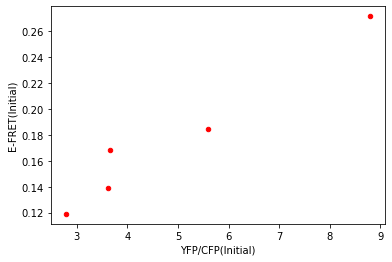

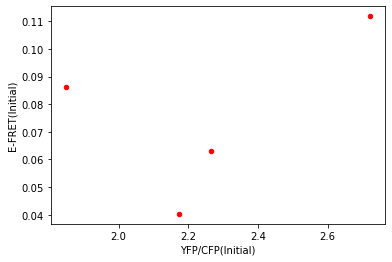

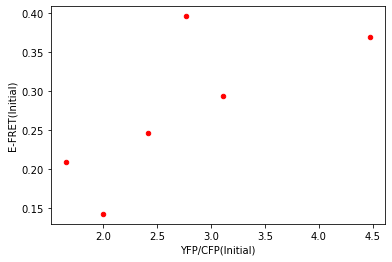

In [203]:
import glob
import os
for f in glob.glob("data/*.xlsx"):
    df = pd.read_excel(f)
    # Date is at row # 4 
    folder = str(pd.to_datetime(df.iat[2, 0]).date())
    do_process(f, folder)